# Author and Institution Networks 
This will be a data exploration of the networks which arrise when we explore the realtionships between and around authors and institiues in health infomatics

In [20]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pyvis.network import Network 
from IPython.display import display
import plotly.express as px

In [2]:
# import excel document into project
df = pd.read_csv(r"review_data.csv",skipinitialspace = True)
df = pd.DataFrame(df)

In [3]:
# List of columns to delete and then dropping them.
delete = ['Study ID','Covidence #','Reviewer Name','Title','Title.1','Type of publication','Study design','Architecture of the Digital Twin','Level of maturity','What is the purpose of the Digital twin', 'Application domain',  ]
df.drop(delete, axis=1, inplace=True)

In [4]:
# move authors into their own rows
df['List of authors'] = df['List of authors'].str.split(';')
df = df.explode('List of authors')
# remove rows where 'List of authors' is null
df.dropna(subset=['List of authors'],inplace=True)
# remove rows where the length of the name is less than 1
df = df[df['List of authors'].str.len() >= 1]
display(df)

,Study ID.1,List of authors,Country in which the study conducted,Year published,"Authors use the term ""digital twin"""
0,949,"Ricci, A",Other: Italy,2022,Yes
0,949,"Croatti, A.",Other: Italy,2022,Yes
0,949,"Montagna, S.",Other: Italy,2022,Yes
1,947,"Hussain, A.",Other,2022,Yes
1,947,"Yaseen, M.U.",Other,2022,Yes
...,...,...,...,...,...
36,33,"Greaves,R.","EU (other than Germany/France); Other: France,...",2023,Yes
36,33,"Dabla,P.","EU (other than Germany/France); Other: France,...",2023,Yes
36,33,"Bernardini,S.","EU (other than Germany/France); Other: France,...",2023,Yes
36,33,"Gouget,B.","EU (other than Germany/France); Other: France,...",2023,Yes


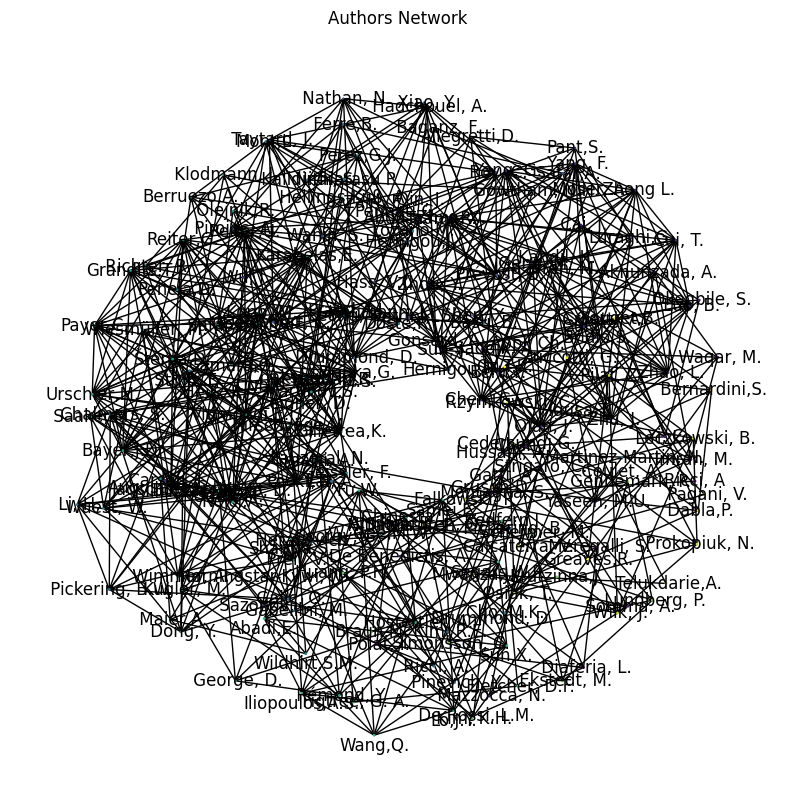

In [5]:

# Step 1: Extract authors and co-authors
authors = df['List of authors'].tolist()
co_authors = df.groupby('Study ID.1')['List of authors'].apply(lambda x: x.tolist()).tolist()

# Step 2: Create a graph object
G = nx.Graph()

# Step 3: Add nodes
G.add_nodes_from(authors)

# Step 4: Add edges
for co_author_list in co_authors:
    for i in range(len(co_author_list)):
        for j in range(i+1, len(co_author_list)):
            author1 = co_author_list[i]
            author2 = co_author_list[j]
            if G.has_edge(author1, author2):
                # Increment edge weight if authors collaborated on multiple studies
                G[author1][author2]['weight'] += 1
            else:
                G.add_edge(author1, author2, weight=1)

# Step 5: Customize visualization
country_labels = df['Country in which the study conducted'].unique()
country_to_label = {country: label for label, country in enumerate(country_labels)}
node_colors = [country_to_label[df.loc[df['List of authors'] == author]['Country in which the study conducted'].iloc[0]] for author in G.nodes()]

node_sizes = [df.loc[df['List of authors'] == author].shape[0] for author in G.nodes()]  # Use number of studies as node sizes

# Step 6: Position nodes
pos = nx.kamada_kawai_layout(G)

# Step 7: Render and display the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, pos, node_color=node_colors, node_size=node_sizes, cmap='viridis')
plt.title('Authors Network')
plt.axis('off')
plt.show()


In [6]:
# Create a network object with specific configurations for visualization
net = Network(notebook=True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

# Apply the repulsion algorithm to improve the spacing and layout of nodes
net.repulsion()

# Import the graph structure from the provided graph object G into the network
net.from_nx(G)

# Show and render the network graph within a notebook environment
net.show("authors.html")

authors.html


Because there is number of groups, we will be focusing on the three highlighted below. An analysis of these different groups of authors shows that authors, tend to be grouped by country, meaning authors of the same country are more likely to share the same paper. 
We can also identify another subgroup which is institutions, whilst groups consist of authors who are from the same countries, it is possible to find groups of authors from the same country who have not collaborated. An example of this is, Geissler and Hirschvoge; These two authors are from the same country, however, have not collaborated which implies that there are institutions, whilst we do not know what these institutions are we can see their effects on the way authors are grouped.


## Cleaning dataframe countries column, to separate out countries into their own individual rows

In [14]:
# because some papers have been conducted in multiple countries or dont have a country at all we need to split them by ;
df['Country in which the study conducted'] = df['Country in which the study conducted'].str.split(';')
df = df.explode('Country in which the study conducted')
df = df.reset_index(drop=True)

In [18]:
# for the countries that begin with "other" we can remove their specific countries and just use the 'other' tag.
# it is important to not that some of the data within other contains countries which are listed as not part of other so the results are limited.
# Remove specific countries and use 'Other' tag
df['Country in which the study conducted'] = df['Country in which the study conducted'].apply(lambda x: 'Other' if x.startswith('Other') else x.split(':')[0].strip())

# Reset the index
df = df.reset_index(drop=True)
df

,Study ID.1,List of authors,Country in which the study conducted,Year published,"Authors use the term ""digital twin"""
0,949,"Ricci, A",Other,2022,Yes
1,949,"Croatti, A.",Other,2022,Yes
2,949,"Montagna, S.",Other,2022,Yes
3,947,"Hussain, A.",Other,2022,Yes
4,947,"Yaseen, M.U.",Other,2022,Yes
...,...,...,...,...,...
299,33,"Bernardini,S.",Other,2023,Yes
300,33,"Gouget,B.",EU (other than Germany/France),2023,Yes
301,33,"Gouget,B.",Other,2023,Yes
302,33,"Öz,T.K.",EU (other than Germany/France),2023,Yes


## construct a new dataframe which contains the country and the number of authors that country has, including the study id so we can visualise the biggest studies in that country


In [22]:

# Group by 'Study ID.1' and 'Country in which the study conducted', and count the number of authors
authorCountDF = df.groupby(['Study ID.1', 'Country in which the study conducted']).agg({'List of authors': 'count'}).reset_index()

# Rename the count column
authorCountDF = authorCountDF.rename(columns={'List of authors': 'Author Count'})
authorCountDF

,Study ID.1,Country in which the study conducted,Author Count
0,33,EU (other than Germany/France),6
1,33,Other,6
2,42,Other,3
3,43,Other,7
4,50,Other,3
5,50,US,3
6,59,US,2
7,77,France,2
8,90,Other,6
9,91,Other,4


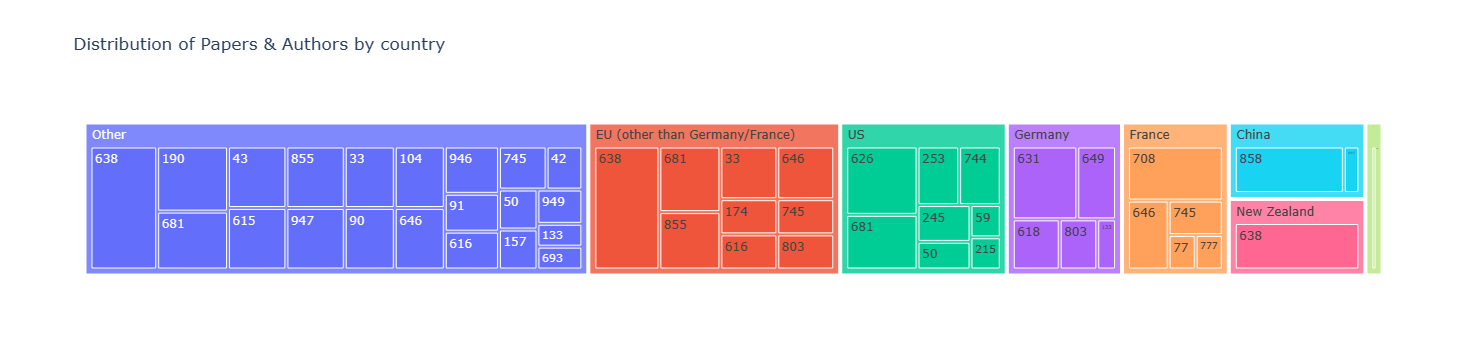

In [34]:
px.treemap(data_frame = authorCountDF,path=['Country in which the study conducted','Study ID.1'], values='Author Count', title="Distribution of Papers & Authors by country")

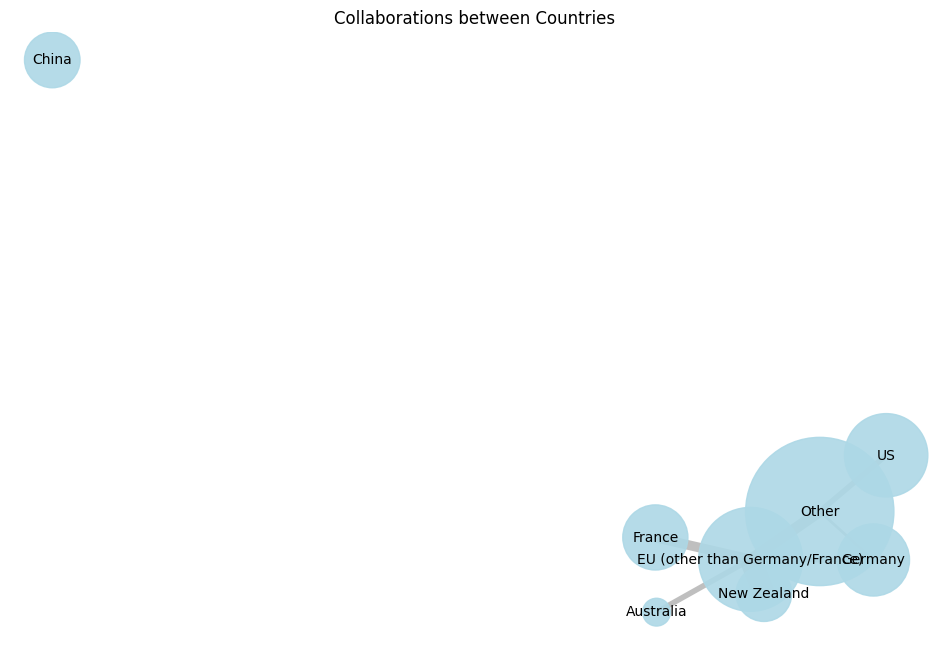

In [30]:
# Create an empty graph
G = nx.Graph()

# Calculate the total number of authors in each country
country_author_counts = df.groupby('Country in which the study conducted')['List of authors'].nunique()

# Add country nodes with sizes based on the total number of authors
for country, count in country_author_counts.items():
    G.add_node(country, size=count)

# Calculate the number of collaborations between countries
collaboration_counts = df.groupby('List of authors')['Country in which the study conducted'].apply(set).apply(list).apply(sorted).apply(tuple).value_counts()

# Add edges between countries based on collaborations
for countries, count in collaboration_counts.items():
    if len(countries) > 1:
        G.add_edge(countries[0], countries[1], weight=count)

# Set positions for the nodes using a spring layout algorithm
pos = nx.spring_layout(G)

# Set node sizes based on the total number of authors in each country
node_sizes = [G.nodes[node]['size'] * 100 for node in G.nodes]

# Set edge widths based on the number of authors involved in collaborations
edge_widths = [G.edges[edge]['weight'] for edge in G.edges]

# Draw the network graph
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title('Collaborations between Countries')
plt.axis('off')
plt.show()

In [31]:
# Create a network object with specific configurations for visualization
net = Network(notebook=True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

# Apply the repulsion algorithm to improve the spacing and layout of nodes
net.repulsion()

# Import the graph structure from the provided graph object G into the network
net.from_nx(G)

# Show and render the network graph within a notebook environment
net.show("authors_countries.html")

authors_countries.html
